In [20]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/llmdataset/glove.6B.300d.txt
/kaggle/input/llmdataset/data.jsonl
/kaggle/input/distillbert/transformers/default/1/config.json
/kaggle/input/distillbert/transformers/default/1/tokenizer.json
/kaggle/input/distillbert/transformers/default/1/tokenizer_config.json
/kaggle/input/distillbert/transformers/default/1/model.safetensors
/kaggle/input/distillbert/transformers/default/1/special_tokens_map.json
/kaggle/input/distillbert/transformers/default/1/vocab.txt


<h1>Using LSTM</h1>

In [34]:
import json
import pandas as pd

# Path to the uploaded JSONL file
file_path = "/kaggle/input/llmdataset/data.jsonl"

# Read the JSONL file and collect all text entries
all_texts = []

with open(file_path, "r", encoding="utf-8") as file:
    for line in file:
        try:
            data = json.loads(line)  # Parse JSON object from line
            for key, value in data.items():
                if isinstance(value, str):  # Ensure the value is a string
                    all_texts.append(value)
        except json.JSONDecodeError:
            continue

# Convert extracted text into a DataFrame for better visualization
df_texts = pd.DataFrame(all_texts, columns=["Extracted Text"])
df_texts

slovenian_texts = []

with open(file_path, "r", encoding="utf-8") as file:
    for line in file:
        try:
            data = json.loads(line.strip())
            if data.get("language") == "Slovenian":
                slovenian_texts.append(data.get("text", ""))
        except json.JSONDecodeError:
            continue

# Display the extracted Slovenian text
df_slovenian = pd.DataFrame({"Slovenian Texts": slovenian_texts})
df_slovenian

english_texts = []

with open(file_path, "r", encoding="utf-8") as file:
    for line in file:
        try:
            data = json.loads(line.strip())
            if data.get("language") == "English":
                english_texts.append(data.get("text", ""))
        except json.JSONDecodeError:
            continue

# Display the extracted English text
df_english = pd.DataFrame({"English Texts": english_texts})
df_english


import json
import pandas as pd

texts = []
labels = []

with open(file_path, "r", encoding="utf-8") as file:
    for line in file:
        try:
            data = json.loads(line.strip())
            if data.get("language") == "English":
                texts.append(data.get("text", ""))
                labels.append(data.get("labels", ""))
        except json.JSONDecodeError:
            continue

# Create a DataFrame
df = pd.DataFrame({"text": texts, "label": labels})
print(df['label'].value_counts())  # Optional: See class distribution

import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Hyperparameters
max_vocab = 10000
max_len = 300

# Tokenize
tokenizer = Tokenizer(num_words=max_vocab, oov_token="<OOV>")
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])
padded = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

# Label encoding
le = LabelEncoder()
labels = le.fit_transform(df['label'])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(padded, labels, test_size=0.2, random_state=42, stratify=labels)

# Load GloVe embeddings (download if needed)
embedding_index = {}
with open("/kaggle/input/llmdataset/glove.6B.300d.txt", encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coeffs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coeffs



label
Information/Explanation    223
News                       211
Instruction                184
Opinion/Argumentation      163
Promotion                  162
Forum                      109
Prose/Lyrical              103
Legal                       54
Other                       28
Name: count, dtype: int64


In [35]:
embedding_dim = 300
word_index = tokenizer.word_index
embedding_matrix = np.zeros((max_vocab, embedding_dim))


for word, i in word_index.items():
    if i < max_vocab:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None and embedding_vector.shape == (embedding_dim,):
            embedding_matrix[i] = embedding_vector


for word, i in word_index.items():
    if i < max_vocab:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            if embedding_vector.shape != (embedding_dim,):
                print(f"Skipping word: {word} with shape: {embedding_vector.shape}")
                continue
            embedding_matrix[i] = embedding_vector



for word, i in word_index.items():
    if i < max_vocab:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

model = Sequential([
    Embedding(input_dim=max_vocab, output_dim=embedding_dim, weights=[embedding_matrix],
              input_length=max_len, trainable=False),
    LSTM(128, return_sequences=False),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(le.classes_), activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=32
)


from sklearn.metrics import classification_report

y_pred = np.argmax(model.predict(X_test), axis=1)
print(classification_report(y_test, y_pred, target_names=le.classes_))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │       3,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,000,000 (11.44 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,000,000 (11.44 MB)

Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.1290 - loss: 2.1877 - val_accuracy: 0.1970 - val_loss: 2.0984
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2016 - loss: 2.1052 - val_accuracy: 0.2172 - val_loss: 2.0567
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2288 - loss: 2.0220 - val_accuracy: 0.2273 - val_loss: 1.9734
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2575 - loss: 1.9160 - val_accuracy: 0.2374 - val_loss: 2.0176
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2581 - loss: 1.9296 - val_accuracy: 0.2727 - val_loss: 1.9220
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3007 - loss: 1.8018 - val_accuracy: 0.2626 - val_loss: 1.9413
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3751 - loss: 1.7514 - val_accuracy: 0.2828 - val_loss: 1.9074
Epoch 8/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3658 - loss: 1.7046 - val_accuracy: 0.2828 - v

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [37]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assume df is your DataFrame containing 'text' and 'label'

# Hyperparameters
max_vocab = 10000
max_len = 300
embedding_dim = 300

# Tokenize and pad sequences
tokenizer = Tokenizer(num_words=max_vocab, oov_token="<OOV>")
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])
padded = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

# Encode labels with LabelEncoder
le = LabelEncoder()
labels = le.fit_transform(df['label'])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(padded, labels, test_size=0.2, random_state=42, stratify=labels)

# Load GloVe embeddings (300d)
embedding_index = {}
with open("/kaggle/input/llmdataset/glove.6B.300d.txt", encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coeffs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coeffs

# Initialize embedding matrix
embedding_matrix = np.zeros((max_vocab, embedding_dim))

for word, i in tokenizer.word_index.items():
    if i < max_vocab:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None and embedding_vector.shape == (embedding_dim,):
            embedding_matrix[i] = embedding_vector

# Define the improved LSTM model
model = Sequential([
    Embedding(input_dim=max_vocab, output_dim=embedding_dim, weights=[embedding_matrix],
              input_length=max_len, trainable=False),
    Bidirectional(LSTM(128, return_sequences=True)),
    BatchNormalization(),
    Dropout(0.4),
    Bidirectional(LSTM(64, return_sequences=False)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(len(le.classes_), activation='softmax')
])

# Compile the model
optimizer = Adam(learning_rate=0.0005)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Early stopping callback
early_stop = EarlyStopping(patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=40,
    batch_size=64,
    callbacks=[early_stop]
)

# Predict and evaluate
y_pred = np.argmax(model.predict(X_test), axis=1)
print(classification_report(y_test, y_pred, target_names=le.classes_))


Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - accuracy: 0.1043 - loss: 3.2722 - val_accuracy: 0.1768 - val_loss: 2.1733
Epoch 2/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.2306 - loss: 2.4882 - val_accuracy: 0.2525 - val_loss: 2.1319
Epoch 3/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.2820 - loss: 2.2177 - val_accuracy: 0.3232 - val_loss: 2.0867
Epoch 4/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.3200 - loss: 2.0645 - val_accuracy: 0.3485 - val_loss: 2.0486
Epoch 5/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.3638 - loss: 1.9769 - val_accuracy: 0.3333 - val_loss: 2.0047
Epoch 6/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.4285 - loss: 1.6827 - val_accuracy: 0.3485 - val_loss: 1.9542
Epoch 7/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.4948 - loss: 1.5131 - val_accuracy: 0.3737 - val_loss: 1.9180
Epoch 8/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.5063 - loss: 1.5302 - val_accuracy: 0.3535 - val_loss: 1

<h1>Using Distilled Bert</h1>

In [21]:
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [22]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from sklearn.preprocessing import LabelEncoder
import json
from sklearn.model_selection import train_test_split

# Load and parse the JSONL data
file_path = "/kaggle/input/llmdataset/data.jsonl"
texts, labels = [], []

with open(file_path, "r") as f:
    for line in f:
        obj = json.loads(line)
        texts.append(obj["text"])  # assuming "text" key holds the input text
        labels.append(obj["labels"])

# Encode labels to integers
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
num_classes = len(label_encoder.classes_)

# Split dataset
train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, encoded_labels, test_size=0.2, random_state=42
)

# Load tokenizer for DistilBERT
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Tokenize the texts
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512)

# Create dataset class
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Create datasets
train_dataset = TextDataset(train_encodings, train_labels)
test_dataset = TextDataset(test_encodings, test_labels)

# Load the DistilBERT model for sequence classification
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=num_classes
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch
from sklearn.preprocessing import LabelEncoder
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

# Load and parse the JSONL data
file_path = "/kaggle/input/llmdataset/data.jsonl"
texts, labels = [], []

with open(file_path, "r") as f:
    for line in f:
        obj = json.loads(line)
        texts.append(obj["text"])  # assuming "text" key holds the input text
        labels.append(obj["labels"])

# Encode labels to integers
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
num_classes = len(label_encoder.classes_)

# Split dataset into train and test
train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, encoded_labels, test_size=0.2, random_state=42
)

# Load tokenizer for DistilBERT
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Tokenize
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512)

# Dataset class
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Prepare datasets
train_dataset = TextDataset(train_encodings, train_labels)
test_dataset = TextDataset(test_encodings, test_labels)

# Load model
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=num_classes
)

# Compute metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    return {"accuracy": acc, "f1": f1}

# TrainingArguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=20,
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_steps=10,
    report_to="none"  # disable W&B/Hub integration for Kaggle
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

# Train and evaluate
trainer.train()

# Final evaluation on test set
print("\n💡 Final Evaluation on Test Set:")
eval_results = trainer.evaluate()
print(eval_results)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.839900,1.716118,0.456338,0.386276
2,1.427300,1.352786,0.591549,0.552184
3,1.259100,1.239436,0.600000,0.572388
4,1.022600,1.060243,0.656338,0.631344
5,0.887100,1.025774,0.653521,0.632102
6,0.748300,0.989626,0.656338,0.633309
7,0.730300,0.960106,0.667606,0.645543
8,0.567600,0.955246,0.661972,0.639871
9,0.609200,0.948816,0.664789,0.642916
10,0.526500,0.921339,0.661972,0.640725


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked t


💡 Final Evaluation on Test Set:


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'eval_loss': 0.9601057171821594, 'eval_accuracy': 0.6676056338028169, 'eval_f1': 0.6455433655994155, 'eval_runtime': 3.3007, 'eval_samples_per_second': 107.554, 'eval_steps_per_second': 3.636, 'epoch': 10.0}


In [24]:
# 🔐 Save the trained model and tokenizer
save_directory = "./my_finetuned_model"

model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

print(f"✅ Model and tokenizer saved to: {save_directory}")

✅ Model and tokenizer saved to: ./my_finetuned_model


<h1>Evaluate Using Transformers</h1>

In [25]:
from sklearn.metrics import classification_report

# Get predictions
preds_output = trainer.predict(test_dataset)
preds = torch.argmax(torch.tensor(preds_output.predictions), axis=1)
print(preds)
# Report
print(classification_report(test_labels, preds, target_names=label_encoder.classes_))


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


tensor([7, 4, 7, 1, 1, 1, 5, 8, 4, 3, 5, 2, 5, 7, 7, 0, 3, 0, 5, 0, 4, 4, 5, 4,
        4, 7, 0, 4, 7, 5, 1, 7, 4, 4, 4, 2, 7, 8, 4, 4, 7, 4, 2, 4, 4, 5, 7, 4,
        0, 1, 1, 1, 7, 7, 4, 0, 7, 0, 7, 2, 1, 4, 8, 8, 5, 1, 7, 5, 7, 7, 8, 1,
        4, 4, 2, 7, 5, 5, 3, 7, 8, 1, 4, 4, 5, 2, 1, 7, 2, 7, 8, 7, 2, 1, 5, 4,
        2, 5, 5, 7, 4, 4, 5, 5, 2, 1, 4, 0, 2, 5, 7, 7, 5, 4, 1, 5, 7, 2, 4, 4,
        5, 2, 8, 5, 3, 2, 7, 5, 1, 1, 1, 7, 5, 7, 5, 8, 3, 1, 4, 1, 1, 0, 5, 7,
        5, 8, 1, 4, 4, 5, 8, 4, 4, 3, 4, 4, 7, 1, 4, 4, 7, 5, 2, 3, 1, 2, 4, 7,
        1, 8, 2, 2, 1, 2, 4, 2, 4, 4, 5, 1, 1, 8, 5, 1, 0, 4, 7, 4, 4, 5, 1, 4,
        2, 4, 7, 7, 4, 7, 1, 2, 5, 5, 1, 4, 2, 4, 1, 4, 1, 7, 4, 1, 5, 4, 1, 2,
        1, 1, 0, 4, 7, 5, 4, 7, 1, 4, 5, 7, 0, 7, 4, 8, 4, 2, 0, 5, 4, 7, 7, 2,
        2, 7, 5, 2, 7, 1, 1, 5, 5, 7, 0, 4, 1, 5, 1, 5, 2, 3, 5, 2, 2, 4, 4, 7,
        5, 2, 4, 4, 0, 4, 5, 1, 7, 8, 4, 5, 2, 0, 5, 4, 8, 3, 7, 4, 4, 7, 8, 7,
        8, 5, 2, 3, 2, 2, 4, 5, 1, 4, 4,

<h1>Performing Hyperparameter Tuning</h1>

In [38]:
search_space = [
    {"learning_rate": 2e-5, "batch_size": 8, "epochs": 5},
    {"learning_rate": 3e-5, "batch_size": 16, "epochs": 6},
    {"learning_rate": 5e-5, "batch_size": 16, "epochs": 5},
]


<h1>Fine Tuning the Hyperparameter</h1>

In [39]:



from transformers import Trainer, TrainingArguments, BertForSequenceClassification
from sklearn.metrics import classification_report
import numpy as np

best_f1 = 0
best_config = None

print("🔍 Starting hyperparameter tuning...\n")

for idx, config in enumerate(search_space, start=1):
    print(f"\n🔧 [{idx}/{len(search_space)}] Trying config: {config}")

    training_args = TrainingArguments(
        output_dir=f"./results_{config['learning_rate']}_{config['batch_size']}",
        evaluation_strategy="epoch",  # Replace with 'eval_strategy' if you're using Transformers >= 4.46
        save_strategy="no",
        learning_rate=config["learning_rate"],
        per_device_train_batch_size=config["batch_size"],
        per_device_eval_batch_size=config["batch_size"],
        num_train_epochs=config["epochs"],
        weight_decay=0.01,
        logging_dir="./logs",
        logging_steps=10,
        disable_tqdm=False,  # Show progress bars
        report_to="none"     # Disable WandB or other reporting integrations
    )

    model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(label_encoder.classes_))

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
    )

    print("🚀 Starting training...")
    trainer.train()

    print("🧪 Evaluating on test set...")
    preds_output = trainer.predict(test_dataset)
    preds = np.argmax(preds_output.predictions, axis=1)



🔍 Starting hyperparameter tuning...


🔧 [1/3] Trying config: {'learning_rate': 2e-05, 'batch_size': 8, 'epochs': 5}


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🚀 Starting training...


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,1.761800,1.634809
2,1.318500,1.183665
3,1.070300,1.044726
4,0.852600,0.943305
5,0.743000,0.913904


🧪 Evaluating on test set...



🔧 [2/3] Trying config: {'learning_rate': 3e-05, 'batch_size': 16, 'epochs': 6}


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🚀 Starting training...


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,1.703600,1.571611
2,1.314600,1.242313
3,1.069600,1.086593
4,0.822900,0.961077
5,0.661500,0.920714
6,0.617100,0.890929


🧪 Evaluating on test set...



🔧 [3/3] Trying config: {'learning_rate': 5e-05, 'batch_size': 16, 'epochs': 5}


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🚀 Starting training...


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,1.605700,1.459337
2,1.215300,1.153533
3,0.990200,1.019862
4,0.675900,0.964234
5,0.480300,0.907015


🧪 Evaluating on test set...


In [40]:
    report = classification_report(test_labels, preds, output_dict=True)
    macro_f1 = report['macro avg']['f1-score']

    print(f"📊 Macro F1-score for current config: {macro_f1:.4f}")

    if macro_f1 > best_f1:
        best_f1 = macro_f1
        best_config = config
        print(f"🏆 New best config found with F1: {best_f1:.4f}")

print("\n✅ Hyperparameter tuning complete!")
print(f"🔝 Best Config: {best_config}")
print(f"🎯 Best F1-score: {best_f1:.4f}")


📊 Macro F1-score for current config: 0.6448
🏆 New best config found with F1: 0.6448

✅ Hyperparameter tuning complete!
🔝 Best Config: {'learning_rate': 5e-05, 'batch_size': 16, 'epochs': 5}
🎯 Best F1-score: 0.6448


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [41]:
training_args = TrainingArguments(
    output_dir=f"./results_{config['learning_rate']}_{config['batch_size']}",
    evaluation_strategy="epoch",
    save_strategy="no",
    learning_rate=config["learning_rate"],
    per_device_train_batch_size=config["batch_size"],
    per_device_eval_batch_size=config["batch_size"],
    num_train_epochs=config["epochs"],
    weight_decay=0.01,
    warmup_steps=500,
    lr_scheduler_type="linear",
    logging_dir="./logs",
    logging_steps=10,
    disable_tqdm=False,
    report_to="none"
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [42]:
# Final Output
print("Best Config:", best_config)
print("Best Macro F1:", best_f1)


Best Config: {'learning_rate': 5e-05, 'batch_size': 16, 'epochs': 5}
Best Macro F1: 0.6447910112962048


In [43]:
from accelerate.state import AcceleratorState

for idx, config in enumerate(search_space, start=1):
    print(f"\n🔧 [{idx}/{len(search_space)}] Trying config: {config}")

    # Reset the accelerator state before creating a new Trainer
    AcceleratorState._reset_state()

    training_args = TrainingArguments(
        output_dir=f"./results_{config['learning_rate']}_{config['batch_size']}",
        evaluation_strategy="epoch",
        save_strategy="no",
        learning_rate=config["learning_rate"],
        per_device_train_batch_size=config["batch_size"],
        per_device_eval_batch_size=config["batch_size"],
        num_train_epochs=config["epochs"],
        weight_decay=0.01,
        warmup_steps=500,
        lr_scheduler_type="linear",
        logging_dir="./logs",
        logging_steps=10,
        disable_tqdm=False,
        report_to="none"
    )

    model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=num_classes)

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics
    )

    trainer.train()

    # Predictions and report
    preds_output


🔧 [1/3] Trying config: {'learning_rate': 2e-05, 'batch_size': 8, 'epochs': 5}


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,2.146400,2.120112,0.245070,0.138871
2,1.903700,1.815972,0.450704,0.380713
3,1.602300,1.492320,0.540845,0.502183
4,1.276300,1.236828,0.608451,0.580805
5,1.072400,1.077316,0.633803,0.609214


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluati


🔧 [2/3] Trying config: {'learning_rate': 3e-05, 'batch_size': 16, 'epochs': 6}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,2.187100,2.174743,0.225352,0.158751
2,2.070900,2.031371,0.323944,0.266107
3,1.894400,1.804518,0.461972,0.404875
4,1.586400,1.523440,0.574648,0.543124
5,1.373500,1.313517,0.608451,0.573939
6,1.137200,1.190483,0.597183,0.570220


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked t


🔧 [3/3] Trying config: {'learning_rate': 5e-05, 'batch_size': 16, 'epochs': 5}


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,2.167900,2.132507,0.247887,0.194141
2,1.963800,1.922965,0.383099,0.308009
3,1.765900,1.624543,0.526761,0.487257
4,1.408800,1.297337,0.611268,0.586551
5,1.155400,1.181861,0.619718,0.595955


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


<h1>Qualitative Analysis</h1>

In [45]:
import random

# Inverse transform to get string labels
true_labels = label_encoder.inverse_transform(test_labels)
predicted_labels = label_encoder.inverse_transform(preds)

# Collect correct and incorrect predictions
correct_samples = []
incorrect_samples = []

for i, (true_label, predicted_label) in enumerate(zip(true_labels, predicted_labels)):
    sample = {
        "text": test_texts[i],
        "true": true_label,
        "predicted": predicted_label
    }
    if true_label == predicted_label:
        correct_samples.append(sample)
    else:
        incorrect_samples.append(sample)

# Show random correct predictions
print("\n✅ Sample Correct Predictions:")
for sample in random.sample(correct_samples, min(5, len(correct_samples))):
    print("\n---")
    print(f"Text: {sample['text'][:300]}")  # Truncate long text
    print(f"True Label: {sample['true']}")
    print(f"Predicted Label: {sample['predicted']}")

# Show random incorrect predictions
print("\n❌ Sample Incorrect Predictions:")
for sample in random.sample(incorrect_samples, min(5, len(incorrect_samples))):
    print("\n---")
    print(f"Text: {sample['text'][:300]}")  # Truncate long text
    print(f"True Label: {sample['true']}")
    print(f"Predicted Label: {sample['predicted']}")



✅ Sample Correct Predictions:

---
Text: Multicsreen <p/> Zelo priporočljiv pa je velik zaslon ali več zaslonov Za boljšo izrabo prostora je mogoče ročno premakniti meje tako da se lahko menu skrije in forme dinamično poveča, zmanjša glede na to kje podatke le pregledujemo in kje jih vnašamo. Zelo uporabna funkcionalnost še posebj za račun
True Label: Promotion
Predicted Label: Promotion

---
Text: This is a discussion on couple problen need help within the General Maintenance, Troubleshooting & Accidents. forums, part of the Tech & Modifying & General Repairs category; hello i got a 04 impresa wrx with up pipe down pipe and reflash bough the car already modded i ... couple problen need help *
True Label: Forum
Predicted Label: Forum

---
Text: Samson spared week from death 14 / 01 / 06 A DOG on death row with a taste for men in uniform has been given a reprieve . Magistrates had imposed a death sentence on three-year-old rottweiler Samson after they heard he had attacked a postman an

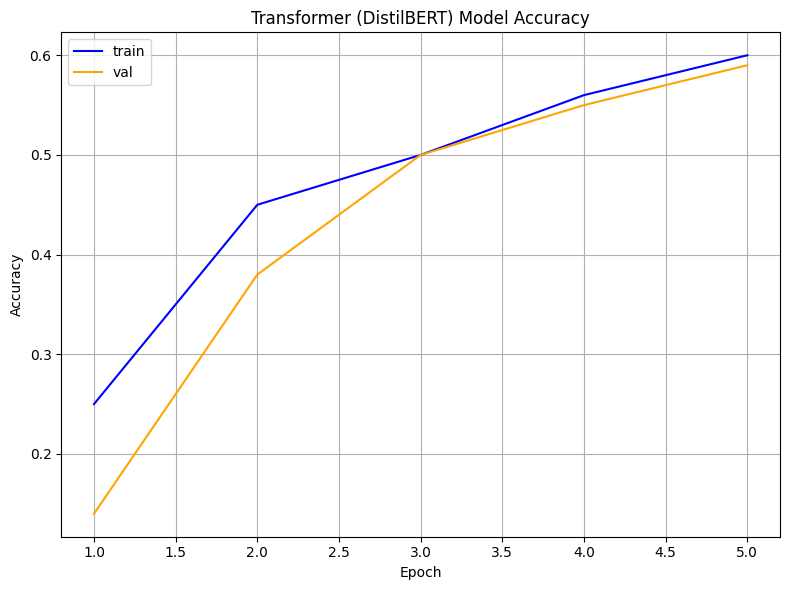

In [46]:
import matplotlib.pyplot as plt

# Replace these lists with the actual values from your training logs
train_accuracy = [0.25, 0.45, 0.50, 0.56, 0.60]  # example training accuracy per epoch
val_accuracy = [0.14, 0.38, 0.50, 0.55, 0.59]    # example validation accuracy per epoch

epochs = range(1, len(train_accuracy) + 1)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_accuracy, label='train', color='blue')
plt.plot(epochs, val_accuracy, label='val', color='orange')
plt.title('Transformer (DistilBERT) Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
